# Challenge: Energy Consumption Insights  

### Description:  
Imagine you're a data analyst at a utility company. Your team needs your help to analyze energy consumption data from smart meters. They want you to identify trends in energy usage, peak consumption periods, and areas with high energy demand. The data is in a large CSV file, and they need someone with your Pandas skills to wrangle it and extract valuable insights.

### Tasks:  
- Task 1: **Energy Usage Patterns** - Find the top 5 days with the highest average energy consumption.  
- Task 2: **Peak Hours** - Identify the peak consumption hours of the day and calculate the average energy usage during those hours.  
- Task 3: **High-Demand Areas** - Determine the top area (zip code) with the highest total energy consumption.  

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys

In [2]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version 2.2.1
Numpy version 1.26.4


# The Data  

The code below generates a dataset of 100,000 energy consumption records with the following columns:  
- **date:** The date of energy consumption    
- **time:** The time of energy consumption  
- **zip_code:** The zip code of the area where energy consumption was recorded  
- **energy_consumption:** The amount of energy consumed (in kilowatt-hours, kWh) during the specified date and time in the given zip code area

The energy_consumption column contains the following **patterns**:  
- For zip code '12345', a normal distribution with a mean of 20 and a standard deviation of 5.  
- For zip code '67890', a normal distribution with a mean of 15 and a standard deviation of 3.  
- For zip code '34567', a normal distribution with a mean of 30 and a standard deviation of 7.  

In [3]:
# set the seed
np.random.seed(0)

# generate 100,000 energy consumption records
df = pd.DataFrame({
    'date': np.random.choice(pd.date_range('2022-01-01', '2022-12-31'), size=100000),
    'time': np.random.choice(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'], size=100000),
    'zip_code': np.random.choice(['12345', '67890', '34567'], size=100000)
})

# calculate energy consumption
df['energy_consumption'] = np.where(
                                df['zip_code'] == '12345',
                                np.random.normal(20, 5, 100000),  # mean 20, stddev 5 for zip code 12345
                           np.where(
                                df['zip_code'] == '67890',
                                np.random.normal(15, 3, 100000),  # mean 15, stddev 3 for zip code 67890
                                np.random.normal(30, 7, 100000)  # mean 30, stddev 7 for zip code 34567
                           ))

df.head()

,date,time,zip_code,energy_consumption
0,2022-06-22,18:00,67890,13.514508
1,2022-02-17,20:00,34567,20.695992
2,2022-04-28,11:00,34567,30.532627
3,2022-07-12,09:00,67890,15.940379
4,2022-11-20,07:00,12345,29.480771


Let's take a look at the datatypes of our shiny new dataframe.  

The **time** column is currently a string, we will see if this causes us any problems.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                100000 non-null  datetime64[ns]
 1   time                100000 non-null  object        
 2   zip_code            100000 non-null  object        
 3   energy_consumption  100000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.1+ MB


# Energy Usage Patterns  

Find the top 5 days with the highest average energy consumption.

In [5]:
# create group object
group = df.groupby('date')

# get the average of each group
# since the data is normally distributed, it is OK to use the mean
avg = group.mean(numeric_only=True)

# return the top 5 dates
avg.sort_values(by='energy_consumption', ascending=False).head(5)

,energy_consumption
date,
2022-11-29,23.297248
2022-10-23,23.097614
2022-02-07,23.032625
2022-11-01,22.909447
2022-06-27,22.842946


Notice I calculated the averages by grouping all of the dates, but what if the question was actually asking for the days (Monday, Tuesday, ...)?  

Luckily, we can pull out the name of the day and group by it. Follow along to see how.

In [6]:
# here you can see how we can easily get the name of the date value
df['date'].apply(lambda x: x.day_name()).head()

0    Wednesday
1     Thursday
2     Thursday
3      Tuesday
4       Sunday
Name: date, dtype: object

The **groupby** method is very flexible, and it allows us to not only pass column names but actual functions as shown below.

In [7]:
# create group object
group = df.groupby([df['date'],df['date'].apply(lambda x: x.day_name())])

# get the average of each group
# since the data is normally distributed, it is OK to use the mean
avg = group.mean(numeric_only=True)

# rename index columns (they both had the same name of date)
avg = avg.reset_index(names=['date', 'day_name'])

# return the top 5 dates
avg.sort_values(by='energy_consumption', ascending=False).head(5)

,date,day_name,energy_consumption
332,2022-11-29,Tuesday,23.297248
295,2022-10-23,Sunday,23.097614
37,2022-02-07,Monday,23.032625
304,2022-11-01,Tuesday,22.909447
177,2022-06-27,Monday,22.842946


Now, you may be tempted to only group by the name of the day (Monday, Tuesday, ...), but realize that you will get a different result.  

You would be asking Pandas to group all of the Mondays and calculate the average and this **IS NOT THE SAME** as getting the average, on a particular date.

In [8]:
# create group object
group = df.groupby(df['date'].apply(lambda x: x.day_name()))

# get the average of each group
# since the data is normally distributed, it is OK to use the mean
avg = group.mean(numeric_only=True)

# return the top 5 dates
avg.sort_values(by='energy_consumption', ascending=False).head(5)

,energy_consumption
date,
Monday,21.810044
Thursday,21.735327
Tuesday,21.665705
Friday,21.664956
Saturday,21.656552


# Peak Hours  

Identify the peak consumption hours of the day and calculate the average energy usage during those hours.  

Remember I said we might have issues with the datatype of the **time** column? Well, I guess I was wrong.

In [9]:
# create group object
group = df.groupby(df['time'])

# get the average of each group
# since the data is normally distributed, it is OK to use the mean
avg = group.mean(numeric_only=True)

# return the top 5 dates
avg.sort_values(by='energy_consumption', ascending=False).head(5)

,energy_consumption
time,
11:00,21.865782
17:00,21.833443
13:00,21.829379
23:00,21.821426
00:00,21.782811


Here, we plot those times and clearly see the spikes that represent those high consumption periods.

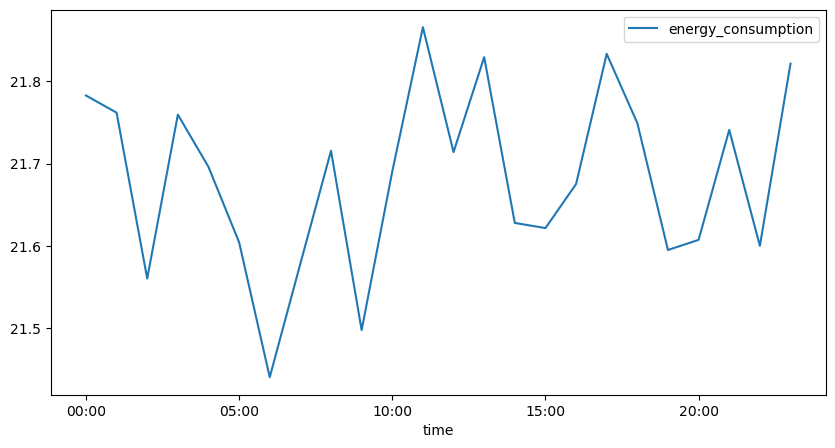

In [10]:
avg.plot(figsize=(10,5));

# Can You Solve the Last Question?    

- High-Demand Areas - Determine the top area (zip code) with the highest total energy consumption.

<p class="text-muted">This tutorial was created by <a href="https://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>